# Typical results
-----------------
The results shown here are obtained from running simulations with the parameters given in the next section.  
These are based mainly in the results shown in the [K-Athena repository](https://gitlab.com/pgrete/kathena/-/wikis/turbulence) and in [Federrath et al. (2010)](https://ui.adsabs.harvard.edu/abs/2011PhRvL.107k4504F/abstract).

### High level temporal evolution

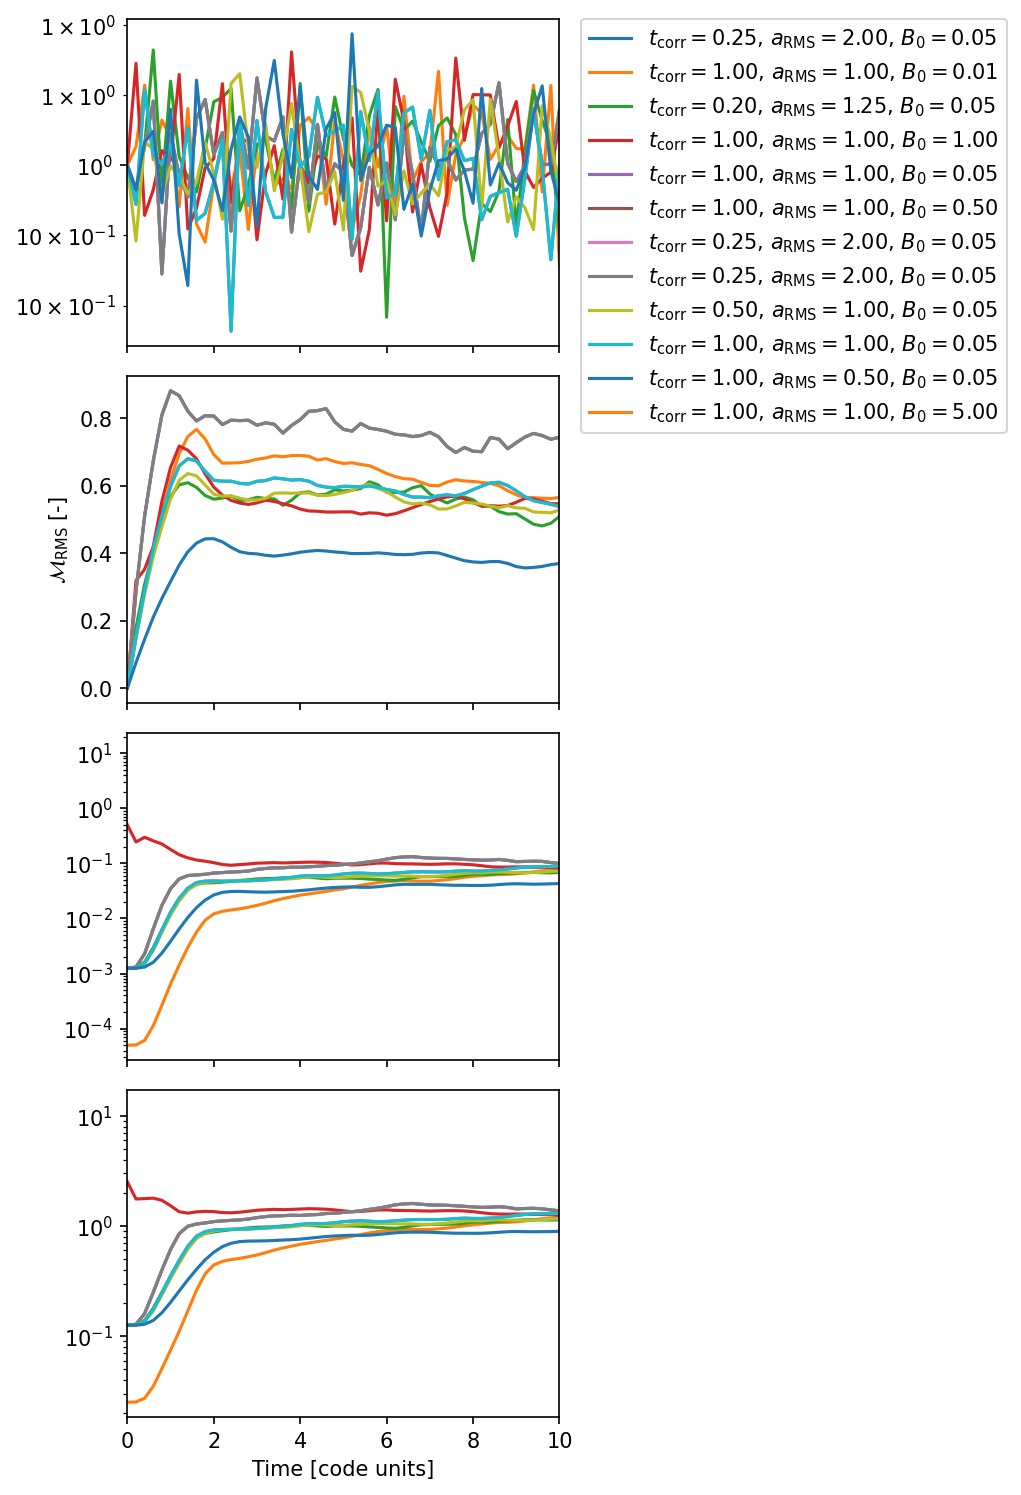

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.model import LoadAthenaPKRun

output_path = "outputs"
fields_for_analysis = ["density", "mach_number", "magnetic_energy_density", "magnetic_field_magnitude"]

runs = os.listdir(output_path)
legend_handles = []

fig, ax = plt.subplots(
    len(fields_for_analysis),
    1,
    dpi=150,
    figsize=(3.5, 10),
    sharex=True
)
for i, run in enumerate(runs):
    if "NG_1-NC_256" in run:
        try:
            sim = LoadAthenaPKRun(os.path.join(output_path, run))
            run_nc = sim.number_of_cells
            run_tcor = sim.correlation_time
            run_arms = sim.acceleration_field_rms
            run_Bini = sim.initial_magnetic_field

            for j, field in enumerate(fields_for_analysis):
                try:
                    df = pd.read_csv(os.path.join(output_path, run, "average_values.txt"), delim_whitespace=True, header=0)
                    ax[j].plot(df["time"], df[field])
                except FileNotFoundError:
                    print(f"WARNING: file `average_values.txt` not found in current `{run}` folder.")
                    pass

            label  = fr'$t_{{\rm corr}}={run_tcor:0.2f}$, '
            label += fr'$a_{{\rm RMS}}={run_arms:0.2f}$, '
            label += fr'$B_0={run_Bini:0.2f}$'
            legend_handles.append(label)

        except AttributeError:
            pass

fig.tight_layout()
ax[0].set_xlim(0, 10)
ax[1].set_ylabel(r'$\mathcal{M}_{\rm RMS}$ [-]')
ax[-1].set_xlabel(r'Time [code units]')
ax[0].set_yscale("log")
ax[2].set_yscale("log")
ax[3].set_yscale("log")

# Todo : fix legend
ax[0].legend(legend_handles, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

### Convergence walltime test
Total walltime for each representative run

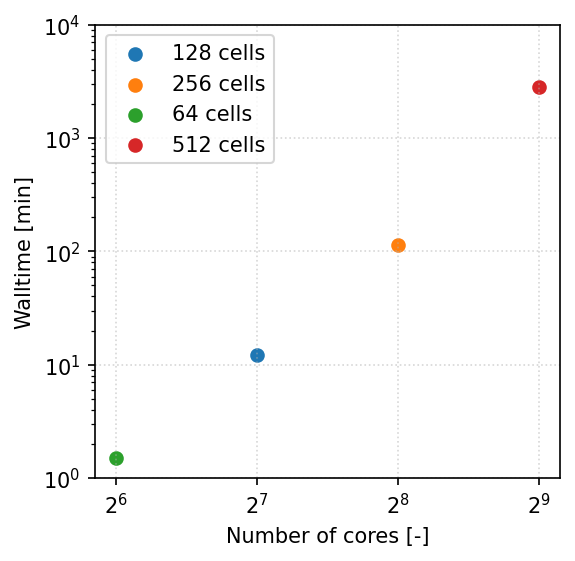

In [20]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(4, 4))

for run in runs:
    try:
        sim = LoadAthenaPKRun(os.path.join(output_path, run))
        run_nc = sim.number_of_cells

        if (
          sim.correlation_time == 1.0
          and sim.equation_of_state == "Adiabatic"
          and sim.acceleration_field_rms == 1.0
          and sim.initial_magnetic_field == 0.05
        ):
            try:
                ax.scatter(run_nc, sim.walltime / 60, label=f"{run_nc} cells")
            except Exception as e:
                raise Warning(f'Error loading snapshot {run} data: {str(e)}')

    except AttributeError:
        pass

ax.grid(True, alpha=0.5, linestyle=":")
ax.set_xlabel(r'Number of cores [-]')
ax.set_ylabel(r'Walltime [min]')
ax.set_xscale('log', base=2)
ax.set_yscale('log')
ax.set_ylim(1e0, 1e4)
ax.legend()

### Consistency of acceleration field

['parthenon.prim.00000.phdf', 'parthenon.prim.00001.phdf', 'parthenon.prim.00002.phdf', 'parthenon.prim.00003.phdf', 'parthenon.prim.00004.phdf', 'parthenon.prim.00005.phdf', 'parthenon.prim.00006.phdf', 'parthenon.prim.00007.phdf', 'parthenon.prim.00008.phdf', 'parthenon.prim.00009.phdf', 'parthenon.prim.00010.phdf', 'parthenon.prim.00011.phdf', 'parthenon.prim.00012.phdf', 'parthenon.prim.00013.phdf', 'parthenon.prim.00014.phdf', 'parthenon.prim.00015.phdf', 'parthenon.prim.00016.phdf', 'parthenon.prim.00017.phdf', 'parthenon.prim.00018.phdf', 'parthenon.prim.00019.phdf', 'parthenon.prim.00020.phdf', 'parthenon.prim.00021.phdf', 'parthenon.prim.00022.phdf', 'parthenon.prim.00023.phdf', 'parthenon.prim.00024.phdf', 'parthenon.prim.00025.phdf', 'parthenon.prim.00026.phdf', 'parthenon.prim.00027.phdf', 'parthenon.prim.00028.phdf', 'parthenon.prim.00029.phdf', 'parthenon.prim.00030.phdf', 'parthenon.prim.00031.phdf', 'parthenon.prim.00032.phdf', 'parthenon.prim.00033.phdf', 'parthenon.pr


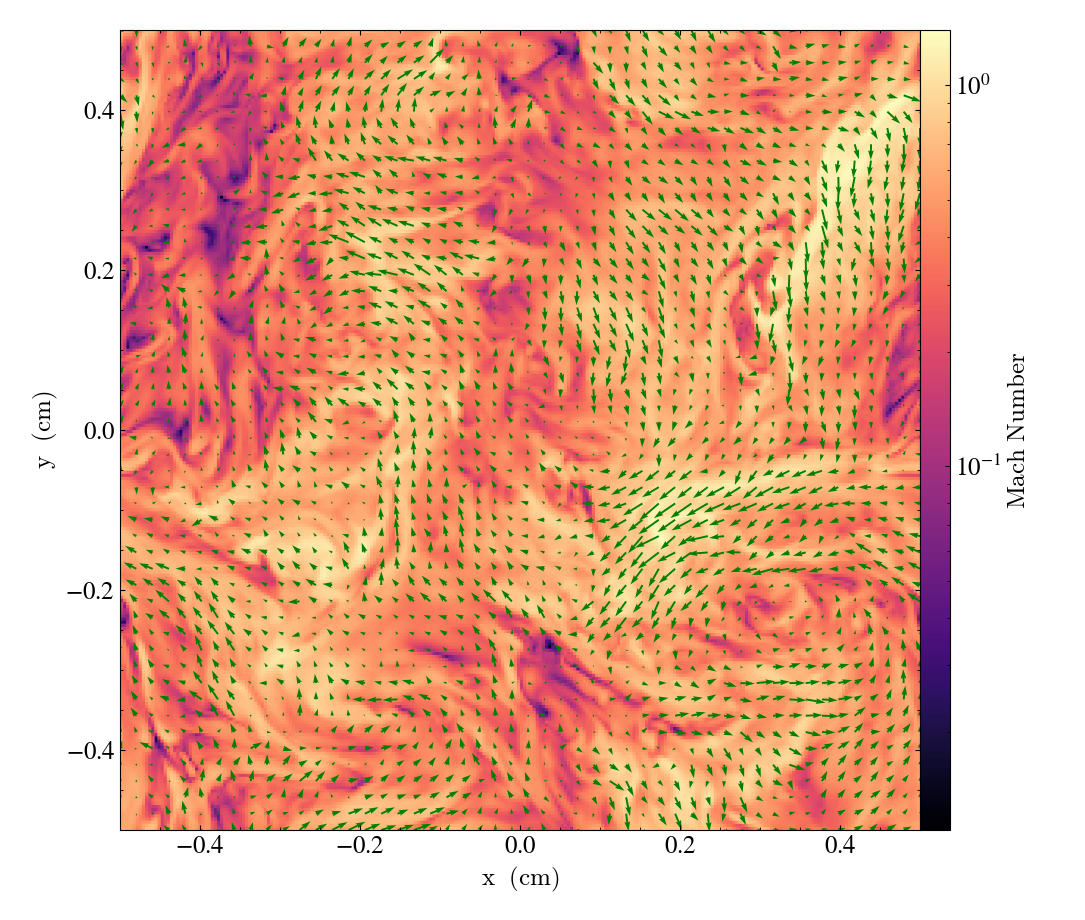

In [2]:
import os
from src.model import LoadAthenaPKRun

# Usage example
run = 'NG_1-NC_256-TCOR_1.00-SOLW_1.00-ARMS_1.00-BINI_0.30-EOSG_1.00'
sim = LoadAthenaPKRun(os.path.join('outputs', run))
print(sim.snapshot_list)

p = sim.plot_snapshot_field(
    'final',
    ('gas', 'mach_number'),
    color_map='magma',
    overplot_velocity=True
)
p.show()

### Velocity dispersion, sound speed velocity and Mach number calculations
The Mach number is calculated as the ratio of the RMS velocity to the sound speed, i.e.,
$$ \mathcal{M} = \frac{v_{\rm rms}}{c_{\rm s}}. $$
Here, the RMS velocity is calculated as:
$$ v_{\rm rms} = \sqrt{v_x^2 + v_y^2 + v_z^2}, $$
and the sound speed is calulated as:
$$ c_{\rm s} = \sqrt{\frac{\gamma P}{\rho}}, $$
with $\gamma$ the adiabatic index, $P$ the gas pressure, and $\rho$ the density.

Fortunately, all these fields are already calculated by the `yt` module when you load a snapshot, as:
```python
ds = yt.load(snapshot_file_path)
ds.all_data()[('gas', 'sound_speed')]
ds.all_data()[('gas', 'mach_number')]
```
and below we can see that they are correctly calculated as if we've done it step by step.

In [5]:
ds = sim.__load_snapshot_data__(25)

def _pressure(field, data):
    return (
        (data.ds.gamma - 1.0)
        * data["gas", "density"]
        * data["gas", "specific_thermal_energy"]
    )
ds.add_field(("gas", "pressure"), function=_pressure, sampling_type="local", units="g/(cm*s**2)")
P = ds.all_data()[("gas", "pressure")]
c_s = np.sqrt(ds.gamma * P / ds.all_data()[("gas", "density")])

def _velocity_rms(field, data):
    return np.sqrt(
        data[("gas", "velocity_x")] ** 2 +
        data[("gas", "velocity_y")] ** 2 +
        data[("gas", "velocity_z")] ** 2
    )
ds.add_field(("gas", "velocity_rms"), function=_velocity_rms, sampling_type="local",  units="cm/s")
v_rms = ds.all_data()[("gas", "velocity_rms")]
mach_number = v_rms / c_s

# Print comparison of our calculated pressure with the yt built-in sound speed for debugging purposes.
print(f">> Pressure:")
print(f"   Our calculated pressure: {P}")
print(f"   yt built-in pressure: {ds.all_data()[('gas', 'pressure')]}")

# Print comparison of our calculated sound speed with the yt built-in sound speed for debugging purposes.
print(f">> Sound speed:")
print(f"   Our calculated sound speed: {c_s}")
print(f"   yt built-in sound speed: {ds.all_data()[('gas', 'sound_speed')]}")

# Print comparison of our calculated Mach number with the yt built-in Mach number for debugging purposes.
print(f">> Mach number:")
print(f"   Our calculated Mach number: {mach_number}")
print(f"   yt built-in Mach number: {ds.all_data()[('gas', 'mach_number')]}")

>> Pressure:
   Our calculated pressure: [0.89588857 0.89168596 0.88903826 ... 0.89258415 0.89959949 0.90244395] dyn/cm**2
   yt built-in pressure: [0.89588857 0.89168596 0.88903826 ... 0.89258415 0.89959949 0.90244395] dyn/cm**2
>> Sound speed:
   Our calculated sound speed: [1.00009162 1.00010231 1.00010394 ... 1.00011645 1.00010023 1.00008867] sqrt(cm)*sqrt(dyn)/sqrt(g)
   yt built-in sound speed: [1.00009162 1.00010231 1.00010394 ... 1.00011645 1.00010023 1.00008867] cm/s
>> Mach number:
   Our calculated Mach number: [0.85457722 0.78502752 0.7634769  ... 1.15339314 1.12132708 1.02695802] sqrt(cm)*sqrt(g)/(sqrt(dyn)*s)
   yt built-in Mach number: [0.85457722 0.78502752 0.7634769  ... 1.15339314 1.12132708 1.02695802] dimensionless
